Loading os and trying to use GPU 

In [11]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
# check tf version
print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
for device in gpus:
    tf.config.experimental.set_memory_growth(device, True)
    print(f"Found GPU {device.name}, and set memory growth to True.")


2.20.0


In [12]:
#base path is the location of the repo on your computer
BASE_PATH = r"C:\Users\avark\Documents\snek"
#BASE_PATH = r"D:\Egyetem_adat"

In [13]:
from sklearn.preprocessing import LabelEncoder

species = pd.read_csv(r"D:\Egyetem_adat\train_images_metadata.csv", index_col=0)
venomous = pd.read_csv(r"D:\Egyetem_adat\venomous_status_metadata.csv", index_col=0)

"""
#read the train_images_metadata.csv file
species = pd.read_csv(BASE_PATH + r"\src\Data\train_images_metadata.csv", index_col=0)

#read the venomous_status_metadata.csv file
venomous = pd.read_csv(BASE_PATH + r"\src\Data\venomous_status_metadata.csv", index_col=0)
"""
#merging the 2 files, now every row from species contains a column with venomous status
combined = species.merge(venomous[["class_id", "MIVS"]], on="class_id", how="left")

#choosing the data you need for machine learning
relevant_info = combined[["binomial_name", "class_id", "MIVS", "image_path"]]

#encoded_id is same as class_id, but starts from 0
encoder = LabelEncoder()
relevant_info["encoded_id"] = encoder.fit_transform(relevant_info["class_id"])
num_classes = len(encoder.classes_)


print(relevant_info.head())

         binomial_name  class_id  MIVS      image_path  encoded_id
0       Bitis caudalis       157     0      168482.JPG           9
1   Amphiesma stolatum        66     0    59067968.jpg           3
2        Lachesis muta       857     1    42704088.jpg         126
3         Vipera berus      1736     1  111487306.jpeg         284
4  Coronella austriaca       387     0  111486989.jpeg          49


<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
C:\Users\janos\AppData\Local\Temp\ipykernel_20840\2163187207.py:8: SyntaxWarning: invalid escape sequence '\s'
  species = pd.read_csv(BASE_PATH + r"\src\Data\train_images_metadata.csv", index_col=0)
C:\Users\janos\AppData\Local\Temp\ipykernel_20840\2163187207.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_info["encoded_id"] = encoder.fit_transform(relevant_info["class_id"])


Loading python images from folder

In [14]:
class_counts = relevant_info["encoded_id"].value_counts().sort_index()

counts_list = class_counts.tolist()



print("Class counts by encoded_id:")
print(class_counts)

print("\nCounts list:", counts_list)



Class counts by encoded_id:
encoded_id
0      109
1      514
2      113
3      251
4      110
      ... 
291    239
292    133
293    925
294    199
295    174
Name: count, Length: 296, dtype: int64

Counts list: [109, 514, 113, 251, 110, 104, 137, 123, 447, 154, 561, 717, 232, 103, 148, 143, 193, 398, 188, 462, 523, 117, 149, 341, 181, 117, 108, 129, 123, 141, 180, 222, 179, 170, 119, 350, 235, 117, 206, 105, 305, 190, 210, 233, 121, 170, 153, 403, 228, 1489, 250, 141, 143, 212, 152, 165, 234, 155, 121, 166, 142, 150, 169, 102, 152, 129, 312, 114, 101, 123, 138, 141, 127, 438, 155, 228, 230, 249, 378, 172, 369, 389, 169, 113, 118, 355, 204, 115, 231, 164, 186, 281, 192, 102, 227, 281, 145, 126, 358, 153, 372, 218, 108, 154, 192, 170, 129, 272, 137, 414, 217, 143, 110, 122, 151, 181, 305, 131, 109, 251, 108, 114, 129, 218, 701, 1065, 142, 219, 156, 146, 154, 139, 331, 145, 366, 111, 206, 265, 169, 259, 286, 696, 288, 150, 125, 435, 203, 162, 108, 138, 159, 100, 324, 293, 258, 160, 142,

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

IMAGE_RESOLUTION=28


# Create a TensorFlow dataset for image loading
def load_img(path):
    img = tf.io.read_file(path)

    #3 channels because of rgb
    #img = tf.image.decode_jpeg(img, 3)
    #expand_animations = False needed, otherwise it
    img = tf.image.decode_image(img, channels=3, expand_animations = False)  
    img = tf.image.resize(img, [IMAGE_RESOLUTION, IMAGE_RESOLUTION])
    img = img / 255.0  # Normalize to [0, 1]
    return img

# Find all of the image_paths 
#image_path = [os.path.join(BASE_PATH, 'src', 'Data', 'train_images_small', img_path) for img_path in relevant_info['image_path'].values]
image_path = [os.path.join(r"D:\Egyetem_adat\train_images_small\train_images_small", img_path) for img_path in relevant_info['image_path'].values]  

# Create the dataset and apply transformations
ds = tf.data.Dataset.from_tensor_slices(image_path)
ds = ds.map(load_img, num_parallel_calls=AUTOTUNE)  # Load images in parallel
ds = ds.batch(32).prefetch(AUTOTUNE)  # Batch and prefetch for efficiency


In [16]:

# Labels are going to be either venomous, or non-venomous
labels_species = relevant_info['encoded_id'].values
labels_venom = relevant_info['MIVS'].values

#return processed image and corresponding label
def generator():
    for img_path, species_label, venom_label in zip(image_path, labels_species, labels_venom):
        img = load_img(img_path)
        yield img, {'species': species_label, 'venom': venom_label}


# Create dataset
dataset = tf.data.Dataset.from_generator(
    generator,
    output_signature=(
        tf.TensorSpec(shape=(IMAGE_RESOLUTION, IMAGE_RESOLUTION, 3), dtype=tf.float32),
        {
            'species': tf.TensorSpec(shape=(), dtype=tf.int32),
            'venom': tf.TensorSpec(shape=(), dtype=tf.int32)
        }
    )
)

# Batch and prefetch for efficiency
BATCH_SIZE = 16
dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [17]:
from collections import Counter

def balance_species_dataset(image_paths, species_labels, venom_labels):
    from collections import Counter
    species_labels = np.array(species_labels)
    venom_labels = np.array(venom_labels)
    image_paths = np.array(image_paths)

    counts = Counter(species_labels)
    values = np.array(list(counts.values()))
    target_count = int(np.median(values))

    new_image_paths = []
    new_species_labels = []
    new_venom_labels = []

    for label in np.unique(species_labels):
        indices = np.where(species_labels == label)[0]
        n_samples = len(indices)

        if n_samples < target_count:
            extra_indices = np.random.choice(indices, target_count - n_samples, replace=True)
            final_indices = np.concatenate([indices, extra_indices])
        elif n_samples > target_count:
            final_indices = np.random.choice(indices, target_count, replace=False)
        else:
            final_indices = indices

        new_image_paths.extend(image_paths[final_indices])
        new_species_labels.extend(species_labels[final_indices])
        new_venom_labels.extend(venom_labels[final_indices])

    #print(f"Balanced dataset created: {len(np.unique(species_labels))} classes")
    #print(f"  Target per class: {target_count}")
    #print(f"  Original size: {len(image_paths)}, New size: {len(new_image_paths)}")

    return np.array(new_image_paths), np.array(new_species_labels), np.array(new_venom_labels)


In [18]:
class DynamicBalancingCallback(tf.keras.callbacks.Callback):
    def __init__(self, image_paths, species_labels, venom_labels, batch_size=16):
        super().__init__()
        self.image_paths = np.array(image_paths)
        self.species_labels = np.array(species_labels)
        self.venom_labels = np.array(venom_labels)
        self.batch_size = batch_size

    def on_epoch_begin(self, epoch, logs=None):
        new_paths, new_species, new_venom = balance_species_dataset(
            self.image_paths, self.species_labels, self.venom_labels
        )

        new_train_dataset = tf.data.Dataset.from_tensor_slices(
            (new_paths, {'species': new_species, 'venom': new_venom})
        )
        new_train_dataset = new_train_dataset.map(
            lambda x, y: (load_img(x), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        new_train_dataset = new_train_dataset.batch(self.batch_size).prefetch(tf.data.AUTOTUNE)

        self.model.train_dataset = new_train_dataset



In [19]:
from sklearn.model_selection import train_test_split

#train_image_paths = [os.path.join(BASE_PATH, 'src', 'Data', 'train_images_small', path) for path in relevant_info["image_path"]]
train_image_paths = [os.path.join(r"D:\Egyetem_adat\train_images_small\train_images_small", path) for path in relevant_info["image_path"]]

#labels_species = relevant_info['encoded_id'].values
#labels_venom   = relevant_info['MIVS'].values

train_image_paths, temp_image_paths, train_species_labels, temp_species_labels, train_venom_labels, temp_venom_labels = train_test_split(
    train_image_paths, labels_species, labels_venom, test_size=0.2, random_state=42, stratify=labels_species
)

val_image_paths, test_image_paths, val_species_labels, test_species_labels, val_venom_labels, test_venom_labels = train_test_split(
    temp_image_paths, temp_species_labels, temp_venom_labels, test_size=0.5, random_state=42, stratify=temp_species_labels
)



train_image_paths_bal, train_species_labels_bal, train_venom_labels_bal = balance_species_dataset(
    train_image_paths,
    train_species_labels,
    train_venom_labels
)
val_image_paths_bal, val_species_labels_bal, val_venom_labels_bal = balance_species_dataset(
    val_image_paths,
    val_species_labels,
    val_venom_labels
)



# Train dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_image_paths_bal, {'species': train_species_labels_bal, 'venom': train_venom_labels_bal})
)
train_dataset = train_dataset.map(
    lambda x, y: (load_img(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
print("Balanced species label distribution:")
print(Counter(train_species_labels_bal))




val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_image_paths_bal, {'species': val_species_labels_bal, 'venom': val_venom_labels_bal})
)
val_dataset = val_dataset.map(
    lambda x, y: (load_img(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

print("Balanced validation species label distribution:")
print(Counter(val_species_labels_bal))


Balanced species label distribution:
Counter({np.int64(0): 124, np.int64(1): 124, np.int64(2): 124, np.int64(3): 124, np.int64(4): 124, np.int64(5): 124, np.int64(6): 124, np.int64(7): 124, np.int64(8): 124, np.int64(9): 124, np.int64(10): 124, np.int64(11): 124, np.int64(12): 124, np.int64(13): 124, np.int64(14): 124, np.int64(15): 124, np.int64(16): 124, np.int64(17): 124, np.int64(18): 124, np.int64(19): 124, np.int64(20): 124, np.int64(21): 124, np.int64(22): 124, np.int64(23): 124, np.int64(24): 124, np.int64(25): 124, np.int64(26): 124, np.int64(27): 124, np.int64(28): 124, np.int64(29): 124, np.int64(30): 124, np.int64(31): 124, np.int64(32): 124, np.int64(33): 124, np.int64(34): 124, np.int64(35): 124, np.int64(36): 124, np.int64(37): 124, np.int64(38): 124, np.int64(39): 124, np.int64(40): 124, np.int64(41): 124, np.int64(42): 124, np.int64(43): 124, np.int64(44): 124, np.int64(45): 124, np.int64(46): 124, np.int64(47): 124, np.int64(48): 124, np.int64(49): 124, np.int64(50): 

In [20]:
from tensorflow.keras.layers import Flatten, Conv2D, Dense, Input, MaxPooling2D, Dropout, Rescaling
from tensorflow.keras import Model

from re import X

input = Input(shape=(IMAGE_RESOLUTION, IMAGE_RESOLUTION, 3))
x = Rescaling(1./255)(input)

x = Conv2D(32, (3,3), padding='same', activation="relu")(input)
x = MaxPooling2D((2,2), padding='valid')(x)

x = Conv2D(64, (3,3), padding='same', activation="relu")(x)
x = MaxPooling2D((2,2), padding='valid')(x)

x = Conv2D(128, (3,3), padding='same', activation="relu")(x)
x = MaxPooling2D((2,2), padding='valid')(x)

x = Conv2D(32, (3,3), padding='same', activation="relu")(x)
x = MaxPooling2D((2,2), padding='valid')(x)

x = Flatten()(x)

x = Dense(128, activation='relu')(x)

x = Dropout(0.3)(x)

species_output = Dense(num_classes, activation='softmax', name='species')(x)
venom_output = Dense(1, activation='sigmoid', name='venom')(x)

model = Model(inputs=input, outputs=[species_output, venom_output])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 14,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 7, 7, 64)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 7, 7, 128) │     73,856 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 3, 3, 128) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 3, 3, 32)  │     36,896 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 1, 1, 32)  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      4,224 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ species (Dense)     │ (None, 296)       │     38,184 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ venom (Dense)       │ (None, 1)         │        129 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 172,681 (674.54 KB)

 Trainable params: 172,681 (674.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def custom_species_loss(y_true, y_pred):
    """Species classification loss with custom weighting"""
    return tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

def custom_venom_loss(y_true, y_pred):
    """Venom classification loss with extra penalty for venomous snakes"""
    base_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
    penalty_mask = tf.where(y_true > 0.5, (1.0 + 3.7 * (1.0 - y_pred)), 1.0)

    weighted_loss = base_loss * penalty_mask
    return weighted_loss

In [22]:
model.compile(
    optimizer='adam',
    #loss={'species': 'sparse_categorical_crossentropy', 'venom': 'binary_crossentropy'},
    loss={
        'species': 'sparse_categorical_crossentropy',
        'venom': custom_venom_loss
    },
    metrics={
        'species': 'accuracy',
        'venom': 'accuracy'
    }
    )

In [23]:
n_epochs = 10  # number of epochs to train the neural network
# checkpointing based on the validation loss
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('model.keras', monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1)
dynamic_balancer = DynamicBalancingCallback(
    train_image_paths,
    train_species_labels,
    train_venom_labels,
    batch_size=16
)
#for batch in train_dataset.take(1):
#    print(batch)
# model training
model_history = model.fit(
                            x= train_dataset,
                            epochs= n_epochs,
                            validation_data= val_dataset,
                            callbacks=[model_checkpoint_callback, dynamic_balancer])



model.load_weights('model.keras')  # load weights back

Epoch 1/10
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 6.7611 - species_accuracy: 0.0021 - species_loss: 5.7546 - venom_accuracy: 0.6404 - venom_loss: 1.0066
Epoch 1: val_loss improved from None to 6.68856, saving model to model.keras
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - loss: 6.8642 - species_accuracy: 4.6316e-04 - species_loss: 5.8981 - venom_accuracy: 0.6522 - venom_loss: 0.9661 - val_loss: 6.6886 - val_species_accuracy: 0.0034 - val_species_loss: 5.7248 - val_venom_accuracy: 0.2230 - val_venom_loss: 0.9637
Epoch 2/10
1142/1147 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.5240 - species_accuracy: 0.0071 - species_loss: 5.5147 - venom_accuracy: 0.3027 - venom_loss: 1.0092
Epoch 2: val_loss improved from 6.68856 to 6.68486, saving model to model.keras
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 6.7170 - species_accuracy: 0.0011 - species_loss: 5.7503 - venom_accuracy: 0.2919 - venom_loss: 0.9667 - val_loss: 6.6849 - val_species_accuracy: 0.0034 - val_species_

In [24]:
# Create TensorFlow datasets for test
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_image_paths, {'species': test_species_labels, 'venom': test_venom_labels})
)
# Apply preprocessing and map to TensorFlow dataset
test_dataset = test_dataset.map(lambda x, y: (load_img(x), y), num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch the datasets for efficiency
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [25]:
test_history = model.evaluate(test_dataset)
print("Test Loss: ", test_history[0])
print("Test Accuracy: ", test_history[1])

208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 6.6490 - species_accuracy: 0.0017 - species_loss: 5.6989 - venom_accuracy: 0.1992 - venom_loss: 0.9503
Test Loss:  6.648990154266357
Test Accuracy:  5.69885778427124


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


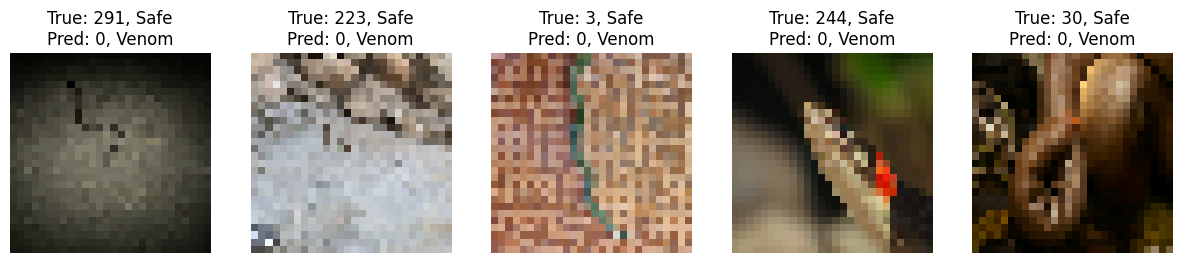

D:\Egyetem_adat\train_images_small\train_images_small\185218337.jpg
D:\Egyetem_adat\train_images_small\train_images_small\232318383.jpeg
D:\Egyetem_adat\train_images_small\train_images_small\126384920.jpeg
D:\Egyetem_adat\train_images_small\train_images_small\233864043.jpeg
D:\Egyetem_adat\train_images_small\train_images_small\72792232.jpeg


In [26]:
#show a few results

def plot_example_results(model, image_paths, true_species_labels, true_venom_labels, num_examples=5):
    indices = np.random.choice(len(image_paths), size=num_examples, replace=False)
    
    plt.figure(figsize=(15, 5))
    
    for i, index in enumerate(indices):
        image_path = image_paths[index]
        true_species = true_species_labels[index]
        true_venom = true_venom_labels[index]
    
        image = load_img(image_path)
        image = tf.expand_dims(image, axis=0)
        
        # Model returns [species_pred, venom_pred]
        species_pred, venom_pred = model.predict(image)
        
        predicted_species = np.argmax(species_pred, axis=1)[0]
        predicted_venom = (venom_pred > 0.5).astype(int)[0][0]
        
        plt.subplot(1, num_examples, i+1)
        plt.imshow(image[0])
        plt.axis('off')
        plt.title(f"True: {true_species}, {'Venom' if true_venom else 'Safe'}\n"
                  f"Pred: {predicted_species}, {'Venom' if predicted_venom else 'Safe'}")
    
    plt.show()
    
    return [image_paths[i] for i in indices]


ex = plot_example_results(model, test_image_paths, test_species_labels, test_venom_labels, num_examples=5)

for i in range(len(ex)):
    print(ex[i])
